In [1]:
%cd ../
!pwd

/home/yoshio/git/second.pytorch
/home/yoshio/git/second.pytorch


In [2]:
import os
import pickle
from pathlib import Path
import re
from functools import partial
import json

import numpy as np
from scipy.special import logit, expit
from scipy import stats
from scipy.optimize import minimize_scalar
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression, LinearRegression, GammaRegressor
from sklearn.pipeline import Pipeline
from sklearn.isotonic import IsotonicRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import patches
from tqdm.notebook import tqdm
import pandas as pd
from PIL import Image
import torch
from IPython.display import display

from utils import *

plt.rcParams['font.family'] = 'Times New Roman' # 全体のフォント
plt.rcParams['font.size'] = 20                  # フォントサイズ

In [3]:
KITTI_INFO = Path(os.environ.get("KITTI_INFO", "/hdd/kitti/kitti_infos_val.pkl"))
# CONF = os.environ.get("CONF", "pointpillars/car/xyres_16-boxunc-corrXY.config")
CONF = os.environ.get("CONF", "pointpillars/car/xyres_16-boxunc.config")
# MODEL = os.environ.get("MODEL", "pointpillars-car-xyres_16-boxunc-corrXY")
MODEL = os.environ.get("MODEL", "pointpillars-car-16-boxunc")
print(KITTI_INFO, CONF, MODEL)

MODEL_DIR = Path(f"./model/{MODEL}")
checkpoint_json = json.loads((MODEL_DIR / "checkpoints.json").read_text())
GSTEP = int(re.search(r"voxelnet-(\d+)\.tckpt", checkpoint_json["latest_ckpt"]["voxelnet"]).group(1))
print("latest step:", GSTEP)

DATA = Path(f"./model/{MODEL}/eval_results/step_{GSTEP}/result_kitti.pkl")
RAWDATA = Path(f"./model/{MODEL}/eval_results/step_{GSTEP}/result.pkl")
MODEL_WEIGHT = MODEL_DIR / f"voxelnet-{GSTEP}.tckpt"


/hdd/kitti/kitti_infos_val.pkl pointpillars/car/xyres_16-boxunc.config pointpillars-car-16-boxunc
latest step: 296960


In [4]:
with KITTI_INFO.open("rb") as f:
    gts = pickle.load(f)

with DATA.open("rb") as f:
    dets = pickle.load(f)

with RAWDATA.open("rb") as f:
    rawdets = pickle.load(f)

In [5]:
data = {
    "y_true": [],
    "conf": [],
    "hull_lidar": [],
    "hull_bev": [],
    "X": [],
    "Y": [],
    "Z": [],
    "Rot": [],
    "W": [], # width
    "L": [], # longitude
    "H": [], # height
    "varX": [],
    "varY": [],
    "varZ": [],
    "varlogW": [],
    "varlogL": [],
    "varlogH": [],
    "varRot": [],
    "Xgt": [],
    "Ygt": [],
    "Zgt": [],
    "Wgt": [],
    "Lgt": [],
    "Hgt": [],
    "Rotgt": [],
    "num_points_in_det": [],
    "xy_correlation_pred": [],
    "sample_idx": [],
}

diagonal = np.sqrt(1.6**2 + 3.9**2)
height = 1.56
for i, (rawdet, det, gt) in enumerate(tqdm(zip(rawdets, dets, gts), total=len(dets))):
    result = det["official/3d_0.70/2/assigned_gt"]
    mask = result != -1 # collect only tp
    data["y_true"].append(np.where(det["official/3d_0.70/2/bin"][mask] == 1, 1, 0))
    data["conf"].append(det["score"][mask])
    data["hull_lidar"].append(det["hull_volumes_in_det"][mask])
    data["hull_bev"].append(det["hull_bev_areas_in_det"][mask])
    raw_indices = det["raw_detection_index"][mask]
    # data["X"].append(det["location"][mask,0])
    # data["Y"].append(det["location"][mask,1])
    # data["Z"].append(det["location"][mask,2])
    data["X"].append(rawdet["box3d_lidar"][raw_indices,0])
    data["Y"].append(rawdet["box3d_lidar"][raw_indices,1])
    data["Z"].append(rawdet["box3d_lidar"][raw_indices,2])
    data["W"].append(rawdet["box3d_lidar"][raw_indices,3])
    data["L"].append(rawdet["box3d_lidar"][raw_indices,4])
    data["H"].append(rawdet["box3d_lidar"][raw_indices,5])
    data["Rot"].append(rawdet["box3d_lidar"][raw_indices, 6])
    data["varX"].append(rawdet["boxvariance_lidar"][raw_indices, 0] * diagonal)
    data["varY"].append(rawdet["boxvariance_lidar"][raw_indices, 1] * diagonal)
    data["varZ"].append(rawdet["boxvariance_lidar"][raw_indices, 2] * height)
    data["varlogW"].append(rawdet["boxvariance_lidar"][raw_indices, 3])
    data["varlogL"].append(rawdet["boxvariance_lidar"][raw_indices, 4])
    data["varlogH"].append(rawdet["boxvariance_lidar"][raw_indices, 5])
    data["varRot"].append(rawdet["boxvariance_lidar"][raw_indices, 6])
    if "box_xy_correlation" in rawdet:
        data["xy_correlation_pred"].append(rawdet["box_xy_correlation"][raw_indices, 0])
    else:
        data["xy_correlation_pred"].append(np.zeros_like(raw_indices))
    indices = result[mask]
    try:
        loc = gt["annos"]["location"][indices]
        dims = gt["annos"]["dimensions"][indices]
        rots = gt["annos"]["rotation_y"][indices]
        gt_boxes_camera = np.concatenate([loc, dims, rots[..., np.newaxis]], axis=1)
        rect = gt["calib"]["R0_rect"]
        Trv2c = gt["calib"]["Tr_velo_to_cam"]
        gt_boxes_lidar = box_camera_to_lidar(gt_boxes_camera, rect, Trv2c)

        # TODO: add variance of box[5]?
        change_box3d_center_(gt_boxes_lidar, [0.5, 0.5, 0], [0.5, 0.5, 0.5])
        data["Xgt"].append(gt_boxes_lidar[:,0])
        data["Ygt"].append(gt_boxes_lidar[:,1])
        data["Zgt"].append(gt_boxes_lidar[:,2])
        data["Wgt"].append(gt_boxes_lidar[:,3])
        data["Lgt"].append(gt_boxes_lidar[:,4])
        data["Hgt"].append(gt_boxes_lidar[:,5])
        data["Rotgt"].append(gt_boxes_lidar[:,6])
    except:
        print(indices)
        raise
    data["num_points_in_det"].append(det["num_points_in_det"][mask])
    data["sample_idx"].append(np.full(mask.sum(), i))

df = pd.DataFrame({key: np.concatenate(val) for key, val in data.items()})
df["angle"] = np.arctan2(df.Y, df.X)
df["angle_gt"] = np.arctan2(df.Ygt, df.Xgt)
df["angle_deg"] = np.arctan2(df.Y, df.X) * 180 / np.pi
df["hull_lidar_ratio"] = df.hull_lidar / (df.W * df.H * df.L)
df["hull_bev_ratio"] = df.hull_bev / (df.W * df.L)
df["RotCam"] = (df.Rot + df.angle) % (2 * np.pi)
df["RotCamgt"] = (df.Rotgt + df.angle_gt) % (2 * np.pi)
df["Sigma_xy"] = df.xy_correlation_pred * np.sqrt(df.varX * df.varY)
df["distance"] = np.sqrt(df.X ** 2 + df.Y ** 2)

df["logW"] = np.log(df.W)
df["logL"] = np.log(df.L)
df["logH"] = np.log(df.H)
df["logWgt"] = np.log(df.Wgt)
df["logLgt"] = np.log(df.Lgt)
df["logHgt"] = np.log(df.Hgt)
assert np.all(df.y_true == 1)
df



  0%|          | 0/3769 [00:00<?, ?it/s]

,y_true,conf,hull_lidar,hull_bev,X,Y,Z,Rot,W,L,...,RotCam,RotCamgt,Sigma_xy,distance,logW,logL,logH,logWgt,logLgt,logHgt
0,1,0.792307,1.339648,3.629533,34.789524,-3.185727,-1.328339,1.552429,1.594233,3.970406,...,1.461112,4.612491,0.0,34.935081,0.466393,1.378868,0.362376,0.457425,1.472472,0.343590
1,1,0.821257,1.608013,4.304275,38.448463,15.728976,-0.924088,1.587260,1.746399,3.858383,...,1.975580,1.957527,0.0,41.541367,0.557556,1.350248,0.386442,0.565314,1.388791,0.398776
2,1,0.785272,2.384941,5.006415,32.084633,2.709633,-0.445147,5.009014,1.676595,4.370844,...,5.093267,5.069643,0.0,32.198849,0.516765,1.474956,0.423235,0.494696,1.463255,0.512824
3,1,0.774071,1.940539,4.116456,19.746603,12.860931,-0.807884,2.746396,1.609046,4.128983,...,3.323684,0.145690,0.0,23.565481,0.475641,1.418031,0.346063,0.482426,1.355835,0.405465
4,1,0.877482,2.698786,4.543505,14.766454,-1.079904,-0.788441,5.025930,1.593775,3.824486,...,4.952928,4.961763,0.0,14.805889,0.466105,1.341424,0.402862,0.470004,1.297463,0.385262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8677,1,0.823761,0.963843,1.903265,13.890309,-5.777318,-1.042152,3.021581,1.562633,4.110628,...,2.627423,2.687467,0.0,15.043873,0.446372,1.413576,0.421035,0.518794,1.378766,0.451076
8678,1,0.778903,1.885232,3.106843,12.688890,7.001294,-0.738603,6.199351,1.705105,4.103639,...,0.420364,3.549247,0.0,14.492276,0.533627,1.411874,0.468766,0.518794,1.355835,0.500775
8679,1,0.734252,0.013716,0.190115,26.404667,6.878308,-0.832422,6.273104,1.610697,3.925979,...,0.244751,3.384905,0.0,27.285849,0.476667,1.367616,0.412828,0.463734,1.490654,0.398776
8680,1,0.708523,0.044730,0.147610,19.040892,-5.794647,-0.738212,3.130862,1.553225,3.810023,...,2.835440,5.953725,0.0,19.903103,0.440333,1.337635,0.397112,0.524729,1.340250,0.570980


In [6]:
def calibreg(name, featall=True, show_img=False, return_imp=False):
    CV = 10

    kf = KFold(CV, shuffle=False)
    X = np.arange(df.sample_idx.max()+1)
    calibed_true = []
    calibed_pred = []
    indices = []
    imp = []

    for train_idx, val_idx in kf.split(X, X):
        trainset = df[df.sample_idx.isin(train_idx)]
        valset = df[df.sample_idx.isin(val_idx)]
        indices.append(valset.index.to_numpy())
        calibed_true.append(valset[name].to_numpy())

        if featall:
            X_train = np.vstack([
                logit(trainset.conf.to_numpy()),
                trainset.hull_bev_ratio.to_numpy(),
                np.cos(trainset.angle.to_numpy()), np.sin(trainset.angle.to_numpy()),
                trainset.distance.to_numpy(),
                trainset.Y.to_numpy(),
                np.log(trainset.W.to_numpy()),
                np.log(trainset.L.to_numpy()),
                np.log(trainset.H.to_numpy()),
                np.cos(trainset.Rot.to_numpy()), np.sin(trainset.Rot.to_numpy()),
                np.sin(2*trainset.Rot.to_numpy())**2,
                np.log(trainset.varX.to_numpy()),
                np.log(trainset.varY.to_numpy()),
                np.log(trainset.varZ.to_numpy()),
                np.log(trainset.varlogW.to_numpy()),
                np.log(trainset.varlogL.to_numpy()),
                np.log(trainset.varlogH.to_numpy()),
                np.log(trainset.varRot.to_numpy()),
            ]).T
            X_val = np.vstack([
                logit(valset.conf.to_numpy()),
                valset.hull_bev_ratio.to_numpy(),
                np.cos(valset.angle.to_numpy()), np.sin(valset.angle.to_numpy()),
                valset.distance.to_numpy(),
                valset.Y.to_numpy(),
                np.log(valset.W.to_numpy()),
                np.log(valset.L.to_numpy()),
                np.log(valset.H.to_numpy()),
                np.cos(valset.Rot.to_numpy()), np.sin(valset.Rot.to_numpy()),
                np.sin(2*valset.Rot.to_numpy())**2,
                np.log(valset.varX.to_numpy()),
                np.log(valset.varY.to_numpy()),
                np.log(valset.varZ.to_numpy()),
                np.log(valset.varlogW.to_numpy()),
                np.log(valset.varlogL.to_numpy()),
                np.log(valset.varlogH.to_numpy()),
                np.log(valset.varRot.to_numpy()),
            ]).T
        else:
            X_train = np.log(trainset["var" + name].to_numpy()[:,None])
            X_val = np.log(valset["var" + name].to_numpy()[:,None])

        if name == "Rot":
            y_train = rotdiff(trainset[name].to_numpy(), trainset[name + "gt"].to_numpy()) ** 2
            y_val = rotdiff(valset[name].to_numpy(), valset[name + "gt"].to_numpy()) ** 2
        else:
            y_train = (trainset[name].to_numpy() - trainset[name + "gt"].to_numpy()) ** 2
            y_val = (valset[name].to_numpy() - valset[name + "gt"].to_numpy()) ** 2

        pipe = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('estimator', GammaRegressor())
        ])
        inst = pipe.fit(X_train, y_train)
        calibed_pred.append(inst.predict(X_val))
        imp.append(pipe.steps[1][1].coef_)

    calibed_true = np.concatenate(calibed_true)
    calibed_pred = np.concatenate(calibed_pred)
    indices = np.concatenate(indices)
    if featall:
        feature = (
            "uncalib. logit", "convex hull IoU", "cos(angle)", "sin(angle)", "distance", "Z coordinate", "log(width)", "log(length)", "log(height)", "cos(heading)", "sin(heading)",
            "sin(2*heading)^2",
            "logvarX", "logvarY", "logvarZ", "logvarlogW", "logvarlogL", "logvarlogH", "logvarRot")
    else:
        feature = ("logvar" + name,)

    if show_img:
        fig, ax = plt.subplots(figsize=(7,7))
        ax.barh(np.arange(len(feature)), np.mean(imp, axis=0), xerr=np.std(imp, axis=0, ddof=1))
        ax.set_yticks(np.arange(len(feature)))
        ax.set_yticklabels(feature)
        ax.invert_yaxis()  # labels read top-to-bottom
        ax.set_xlabel('Coefficient')
        ax.grid(True)
        plt.show()
    if return_imp:
        return calibed_pred, feature, np.mean(imp, axis=0)
    return calibed_pred


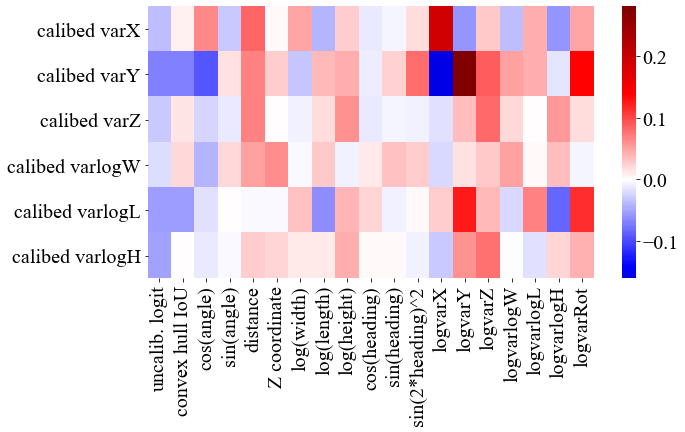

In [7]:
names = ["X", "Y", "Z", "logW", "logL", "logH"]#, "Rot"]
calibed, feats, imps = list(zip(*[calibreg(n, show_img=False, return_imp=True) for n in names]))

plt.figure(figsize=(10, 5))
sns.heatmap(imps, xticklabels=feats[0], yticklabels=["calibed var" + n for n in names], cmap="seismic", center=0)
plt.show()

In [8]:
names = ["X", "Y", "Z", "logW", "logL", "logH", "Rot"]
table = {"name": [], "RECE": [], "RMCE": [], "method": [], "curves": []}

for n in names:
    y_true = df[n].to_numpy()
    y_pred = df[n + "gt"].to_numpy()
    y_var = df["var" + n].to_numpy()

    curve = reg_calibration_curve_angular if n == "Rot" else reg_calibration_curve

    prob_true, prob_pred, count = curve(y_true, y_pred, y_var, n_bins=20)
    ece = (np.abs(prob_true - prob_pred) * count).sum() / count.sum()
    mce = np.abs(prob_true - prob_pred).max()
    table["name"].append(n)
    table["RECE"].append(ece)
    table["RMCE"].append(mce)
    table["method"].append("raw")
    table["curves"].append((prob_true, prob_pred))

    calibed = calibreg(n, show_img=False)
    prob_true, prob_pred, count = curve(y_true, y_pred, calibed, n_bins=20)
    ece = (np.abs(prob_true - prob_pred) * count).sum() / count.sum()
    mce = np.abs(prob_true - prob_pred).max()
    table["name"].append(n)
    table["RECE"].append(ece)
    table["RMCE"].append(mce)
    table["method"].append("gamma")
    table["curves"].append((prob_true, prob_pred))

    if n == "Rot":
        invT = np.mean(rotdiff(y_true, y_pred) ** 2 / y_var)
    else:
        invT = np.mean((y_true - y_pred) ** 2 / y_var)
    calibed = y_var * invT
    prob_true, prob_pred, count = curve(y_true, y_pred, calibed, n_bins=20)
    ece = (np.abs(prob_true - prob_pred) * count).sum() / count.sum()
    mce = np.abs(prob_true - prob_pred).max()
    table["name"].append(n)
    table["RECE"].append(ece)
    table["RMCE"].append(mce)
    table["method"].append("temp.")
    table["curves"].append((prob_true, prob_pred))

table = pd.DataFrame(table)

In [9]:
table.pivot(index="method", columns="name", values="RECE").loc[["raw", "temp.", "gamma"], names]

name,X,Y,Z,logW,logL,logH,Rot
method,,,,,,,
raw,0.083960,0.107170,0.267522,0.268681,0.276282,0.308188,0.222081
temp.,0.035795,0.016341,0.008056,0.017243,0.038122,0.026095,0.727566
gamma,0.020981,0.017678,0.002117,0.010423,0.009496,0.014770,0.603688


In [10]:
table.pivot(index="method", columns="name", values="RMCE").loc[["raw", "temp.", "gamma"], names]

name,X,Y,Z,logW,logL,logH,Rot
method,,,,,,,
raw,0.128196,0.163545,0.396464,0.394736,0.413868,0.450956,0.360654
temp.,0.057487,0.031433,0.014352,0.032711,0.064490,0.043538,0.802903
gamma,0.035165,0.033852,0.006657,0.020283,0.016920,0.028254,0.757521


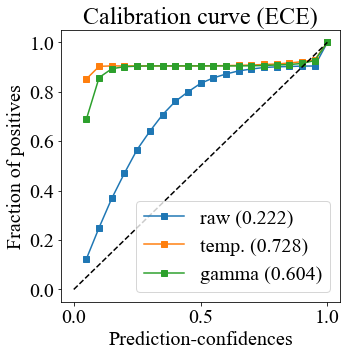

In [11]:
plt.figure(figsize=(5, 5))

for m in ["raw", "temp.", "gamma"]:
    item = table[(table.name == "Rot") & (table.method == m)].iloc[0]
    prob_true, prob_pred = item.curves
    ece = item.RECE
    plt.title("Calibration curve (ECE)")
    plt.plot(prob_pred, prob_true, "s-", label="%s (%.3f)"%(m, ece))
plt.xlim(-0.05, 1.05)
plt.xlabel("Prediction-confidences")
plt.ylabel("Fraction of positives")
plt.legend()

plt.plot([0,1], [0,1], "k--")
plt.show()

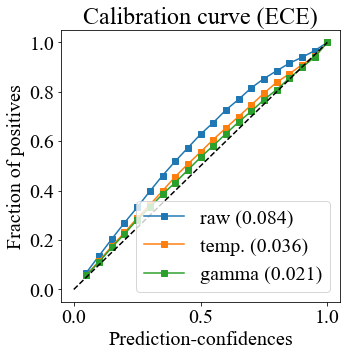

In [12]:
plt.figure(figsize=(5, 5))

for m in ["raw", "temp.", "gamma"]:
    item = table[(table.name == "X") & (table.method == m)].iloc[0]
    prob_true, prob_pred = item.curves
    ece = item.RECE
    plt.title("Calibration curve (ECE)")
    plt.plot(prob_pred, prob_true, "s-", label="%s (%.3f)"%(m, ece))
plt.xlim(-0.05, 1.05)
plt.xlabel("Prediction-confidences")
plt.ylabel("Fraction of positives")
plt.legend()

plt.plot([0,1], [0,1], "k--")
plt.show()

In [13]:
print(table.pivot(index="method", columns="name", values="RECE").loc[["raw", "temp.", "gamma"], names].to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrrrr}
\toprule
name &     X &     Y &     Z &  logW &  logL &  logH &   Rot \\
method &       &       &       &       &       &       &       \\
\midrule
raw    & 0.084 & 0.107 & 0.268 & 0.269 & 0.276 & 0.308 & 0.222 \\
temp.  & 0.036 & 0.016 & 0.008 & 0.017 & 0.038 & 0.026 & 0.728 \\
gamma  & 0.021 & 0.018 & 0.002 & 0.010 & 0.009 & 0.015 & 0.604 \\
\bottomrule
\end{tabular}



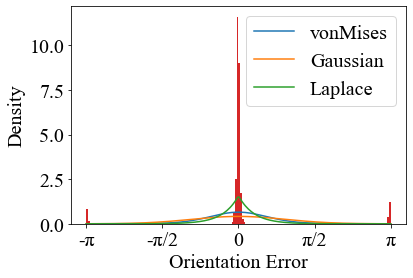

In [14]:
roterrors = (df.Rot - df.Rotgt) % (2*np.pi)
roterrors = np.where(roterrors > np.pi, roterrors - 2*np.pi, roterrors)
# roterrors = roterrors[(-2 < roterrors) & (roterrors < 2)]

kappa, loc, scale = stats.vonmises.fit(roterrors, floc=0, fscale=1)
assert scale == 1
assert loc == 0
x = np.linspace(-np.pi, np.pi, 200)
y = stats.vonmises.pdf(x, kappa)
plt.plot(x, y, label="vonMises")

loc, scale = stats.norm.fit(roterrors, floc=0)
y = stats.norm.pdf(x, scale=scale)
plt.plot(x, y, label="Gaussian")

loc, scale = stats.laplace.fit(roterrors, floc=0)
y = stats.laplace.pdf(x, scale=scale)
plt.plot(x, y, label="Laplace")

plt.hist(roterrors, bins=180, density=True)
plt.xlabel("Orientation Error")
plt.xticks(np.linspace(-np.pi, np.pi, 5, endpoint=True), ["-π", "-π/2", "0", "π/2", "π"])
plt.ylabel("Density")
plt.legend()
plt.show()

In [15]:
def bigamma(name, featall=True, show_img=False, return_imp=False):
    assert name == "Rot"
    CV = 10

    kf = KFold(CV, shuffle=False)
    X = np.arange(df.sample_idx.max()+1)
    calibed_true = []
    calibed_pred = []
    indices = []
    imp = []
    lams = []

    for train_idx, val_idx in kf.split(X, X):
        trainset = df[df.sample_idx.isin(train_idx)]
        valset = df[df.sample_idx.isin(val_idx)]
        indices.append(valset.index.to_numpy())
        calibed_true.append(valset[name].to_numpy())

        diff = rotdiff(trainset.Rot.to_numpy(), trainset.Rotgt.to_numpy())
        mask = (diff > -np.pi/2) & (diff < np.pi/2)
        lam = np.sum(mask) / len(diff)
        for _ in range(len(valset)):
            lams.append(lam)

        if featall:
            X_train = np.vstack([
                logit(trainset.conf.to_numpy()),
                trainset.hull_bev_ratio.to_numpy(),
                np.cos(trainset.angle.to_numpy()), np.sin(trainset.angle.to_numpy()),
                trainset.distance.to_numpy(),
                trainset.Y.to_numpy(),
                np.log(trainset.W.to_numpy()),
                np.log(trainset.L.to_numpy()),
                np.log(trainset.H.to_numpy()),
                np.cos(trainset.Rot.to_numpy()), np.sin(trainset.Rot.to_numpy()),
                np.sin(2*trainset.Rot.to_numpy())**2,
                np.log(trainset.varX.to_numpy()),
                np.log(trainset.varY.to_numpy()),
                np.log(trainset.varZ.to_numpy()),
                np.log(trainset.varlogW.to_numpy()),
                np.log(trainset.varlogL.to_numpy()),
                np.log(trainset.varlogH.to_numpy()),
                np.log(trainset.varRot.to_numpy()),
            ]).T
            X_val = np.vstack([
                logit(valset.conf.to_numpy()),
                valset.hull_bev_ratio.to_numpy(),
                np.cos(valset.angle.to_numpy()), np.sin(valset.angle.to_numpy()),
                valset.distance.to_numpy(),
                valset.Y.to_numpy(),
                np.log(valset.W.to_numpy()),
                np.log(valset.L.to_numpy()),
                np.log(valset.H.to_numpy()),
                np.cos(valset.Rot.to_numpy()), np.sin(valset.Rot.to_numpy()),
                np.sin(2*valset.Rot.to_numpy())**2,
                np.log(valset.varX.to_numpy()),
                np.log(valset.varY.to_numpy()),
                np.log(valset.varZ.to_numpy()),
                np.log(valset.varlogW.to_numpy()),
                np.log(valset.varlogL.to_numpy()),
                np.log(valset.varlogH.to_numpy()),
                np.log(valset.varRot.to_numpy()),
            ]).T
        else:
            X_train = np.log(trainset["var" + name].to_numpy()[:,None])
            X_val = np.log(valset["var" + name].to_numpy()[:,None])

        y_train = rotdiff(trainset[name].to_numpy() - np.where(mask, 0, np.pi), trainset[name + "gt"].to_numpy()) ** 2

        pipe = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('estimator', GammaRegressor())
        ])
        inst = pipe.fit(X_train, y_train)
        calibed_pred.append(inst.predict(X_val))
        imp.append(pipe.steps[1][1].coef_)

    calibed_true = np.concatenate(calibed_true)
    calibed_pred = np.concatenate(calibed_pred)
    indices = np.concatenate(indices)
    if featall:
        feature = (
            "uncalib. logit", "convex hull IoU", "cos(angle)", "sin(angle)", "distance", "Z coordinate", "log(width)", "log(length)", "log(height)", "cos(heading)", "sin(heading)",
            "sin(2*heading)^2",
            "logvarX", "logvarY", "logvarZ", "logvarlogW", "logvarlogL", "logvarlogH", "logvarRot")
    else:
        feature = ("logvar" + name,)

    if show_img:
        fig, ax = plt.subplots(figsize=(7,7))
        ax.barh(np.arange(len(feature)), np.mean(imp, axis=0), xerr=np.std(imp, axis=0, ddof=1))
        ax.set_yticks(np.arange(len(feature)))
        ax.set_yticklabels(feature)
        ax.invert_yaxis()  # labels read top-to-bottom
        ax.set_xlabel('Coefficient')
        ax.grid(True)
        plt.show()
    if return_imp:
        return calibed_pred, feature, np.mean(imp, axis=0)
    return calibed_pred, np.array(lams)

In [16]:
from tqdm import tqdm

def reg_calibration_curve_bigamma(y_true, y_pred, variance_pred, lam, n_bins):
    ci = lambda x,k: (stats.vonmises.cdf(x, kappa=k) - stats.vonmises.cdf(-x, kappa=k))
    y_diff = np.abs(rotdiff(y_true, y_pred))
    y_diff_conf = np.array([
        l * ci(yd, 1/v) + (1-l) * (1-ci(np.pi-yd, 1/v))
        for l, yd, v in tqdm(zip(lam, y_diff, variance_pred), total=len(lam))
    ])

    confidences = np.linspace(0.0, 1.0, n_bins+1, endpoint=True)
    precs = np.zeros(n_bins+1, dtype=np.float32)
    counts = np.zeros(n_bins+1, dtype=np.float32)
    for i, conf in enumerate(confidences):
        precs[i] = np.sum(y_diff_conf <= conf) / len(y_true)
        if i > 0:
            counts[i] = precs[i] * len(y_true) - precs[i-1] * len(y_true)
    return precs[1:], confidences[1:], counts[1:]

In [17]:
names = ["Rot"]
table = {"name": [], "RECE": [], "RMCE": [], "method": [], "curves": []}

for n in names:
    y_true = df[n].to_numpy()
    y_pred = df[n + "gt"].to_numpy()
    y_var = df["var" + n].to_numpy()

    curve = reg_calibration_curve_angular if n == "Rot" else reg_calibration_curve

    prob_true, prob_pred, count = curve(y_true, y_pred, y_var, n_bins=20)
    ece = (np.abs(prob_true - prob_pred) * count).sum() / count.sum()
    mce = np.abs(prob_true - prob_pred).max()
    table["name"].append(n)
    table["RECE"].append(ece)
    table["RMCE"].append(mce)
    table["method"].append("raw")
    table["curves"].append((prob_true, prob_pred))

    calibed = calibreg(n, show_img=False)
    prob_true, prob_pred, count = curve(y_true, y_pred, calibed, n_bins=20)
    ece = (np.abs(prob_true - prob_pred) * count).sum() / count.sum()
    mce = np.abs(prob_true - prob_pred).max()
    table["name"].append(n)
    table["RECE"].append(ece)
    table["RMCE"].append(mce)
    table["method"].append("gamma")
    table["curves"].append((prob_true, prob_pred))

    calibed, lams = bigamma(n, show_img=False)
    prob_true, prob_pred, count = reg_calibration_curve_bigamma(y_true, y_pred, calibed, lams, n_bins=20)
    ece = (np.abs(prob_true - prob_pred) * count).sum() / count.sum()
    mce = np.abs(prob_true - prob_pred).max()
    table["name"].append(n)
    table["RECE"].append(ece)
    table["RMCE"].append(mce)
    table["method"].append("bigamma")
    table["curves"].append((prob_true, prob_pred))

    if n == "Rot":
        invT = np.mean(rotdiff(y_true, y_pred) ** 2 / y_var)
    else:
        invT = np.mean((y_true - y_pred) ** 2 / y_var)
    calibed = y_var * invT
    prob_true, prob_pred, count = curve(y_true, y_pred, calibed, n_bins=20)
    ece = (np.abs(prob_true - prob_pred) * count).sum() / count.sum()
    mce = np.abs(prob_true - prob_pred).max()
    table["name"].append(n)
    table["RECE"].append(ece)
    table["RMCE"].append(mce)
    table["method"].append("temp.")
    table["curves"].append((prob_true, prob_pred))

table = pd.DataFrame(table)


100%|██████████| 8682/8682 [00:06<00:00, 1314.08it/s]


In [18]:
table.pivot(index="method", columns="name", values="RECE").loc[["raw", "temp.", "gamma", "bigamma"], names]

name,Rot
method,
raw,0.222081
temp.,0.727566
gamma,0.603688
bigamma,0.016717


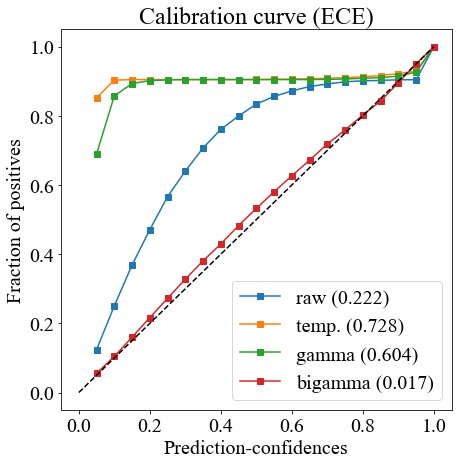

In [19]:
plt.figure(figsize=(7, 7))

for m in ["raw", "temp.", "gamma", "bigamma"]:
    item = table[(table.name == "Rot") & (table.method == m)].iloc[0]
    prob_true, prob_pred = item.curves
    ece = item.RECE
    plt.title("Calibration curve (ECE)")
    plt.plot(prob_pred, prob_true, "s-", label="%s (%.3f)"%(m, ece))
plt.xlim(-0.05, 1.05)
plt.xlabel("Prediction-confidences")
plt.ylabel("Fraction of positives")
plt.legend()

plt.plot([0,1], [0,1], "k--")
plt.show()

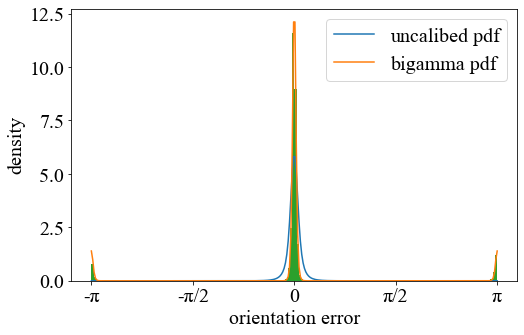

In [20]:
plt.figure(figsize=(8, 5))
roterrors = (df.Rot - df.Rotgt) % (2*np.pi)
roterrors = np.where(roterrors > np.pi, roterrors - 2*np.pi, roterrors)

x = np.linspace(-np.pi, np.pi, 300)
distrs = np.mean([
    stats.vonmises.pdf(x, kappa=1/v)
    for v in df.varRot.to_numpy()
], axis=0)
plt.plot(x, distrs, label="uncalibed pdf", c=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])

calibed, lams = bigamma("Rot", show_img=False)
distrs = np.mean([
    l * stats.vonmises.pdf(x, kappa=1/v) + (1-l) * stats.vonmises.pdf(x, kappa=1/v, loc=np.pi)
    for l, v in zip(lams, calibed)
], axis=0)
plt.plot(x, distrs, label="bigamma pdf", c=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])

plt.hist(roterrors, bins=180, density=True, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][2])
plt.xlabel("orientation error")
plt.xticks(np.linspace(-np.pi, np.pi, 5, endpoint=True), ["-π", "-π/2", "0", "π/2", "π"])
plt.ylabel("density")
plt.legend()
plt.show()

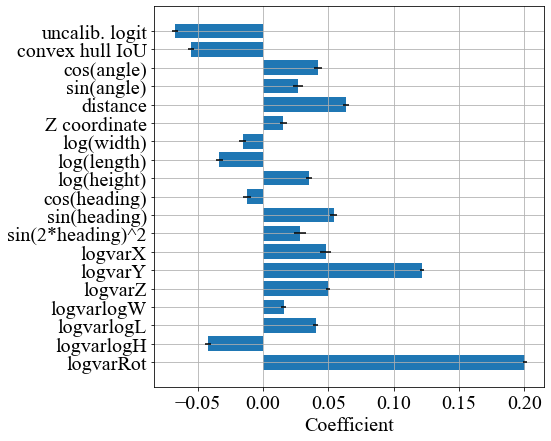

In [21]:
calibed, lams = bigamma(n, show_img=True)